**colorectal tumor dataset analysis building on work by Li et. al https://pubmed.ncbi.nlm.nih.gov/39216476/**

In [2]:
import scanpy as sc
import scvi
import pandas as pd

# load data from crc atlas

In [27]:
adata_fp ="crc1/10X-Illumina-processed/expr.combined.TPM.h5ad"

with open(adata_fp,'rb') as f:
    adata=sc.read_h5ad(f)

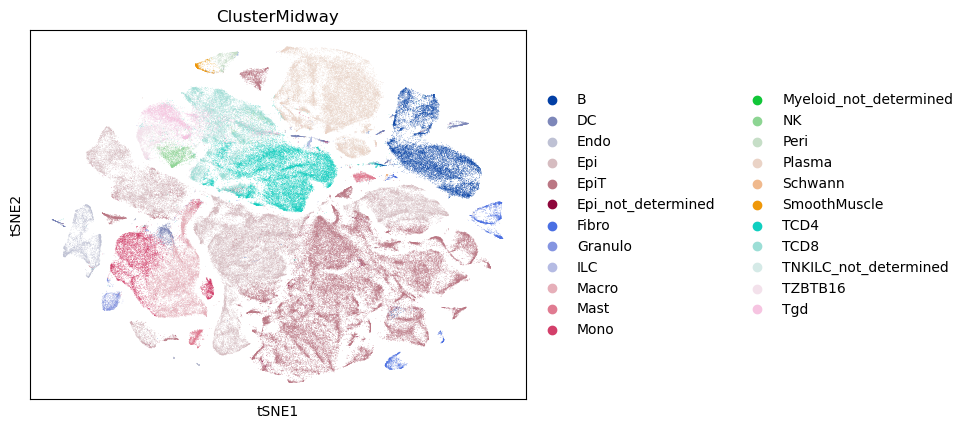

In [32]:
sc.pl.tsne(adata, color="ClusterMidway")

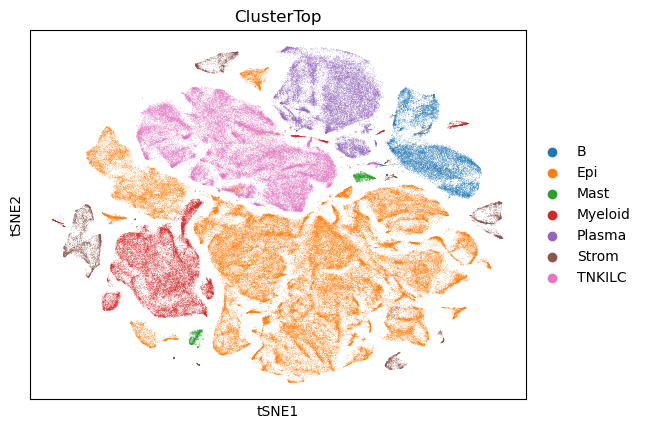

In [43]:
sc.pl.tsne(adata, color="ClusterTop")

In [29]:
adata

AnnData object with n_obs × n_vars = 218966 × 16886
    obs: 'nCount_RNA', 'nFeature_RNA', 'library_id', 'sample_source', 'condition', 'ClusterTop', 'ClusterMidway', 'ClusterFull', 'library_id_short'
    var: 'features', 'unintegrated_features'
    uns: 'ClusterMidway_colors'
    obsm: 'X_tsne'
    layers: 'unintegrated'

# visualzing data from Li et al. (we have isoform expression data for these cells only)

In [41]:
adata.obs["condition_integration"]= adata.obs.apply(lambda row: "c295" if row["sample_source"]=="bc295" else row["condition"], axis=1)

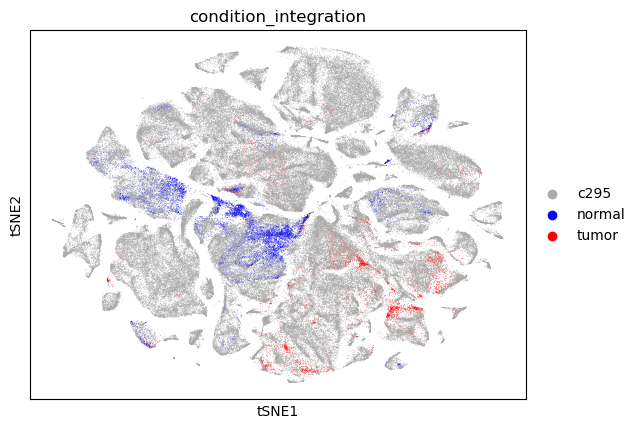

In [42]:
sc.pl.tsne(adata, color="condition_integration", palette={"c295":"#aaaaaa","normal":"blue","tumor":"red"}, size=1, alpha=0.8)

In [44]:
adata.obs["ClusterTop_integration"]= adata.obs.apply(lambda row: "c295" if row["sample_source"]=="bc295" else row["ClusterTop"], axis=1)

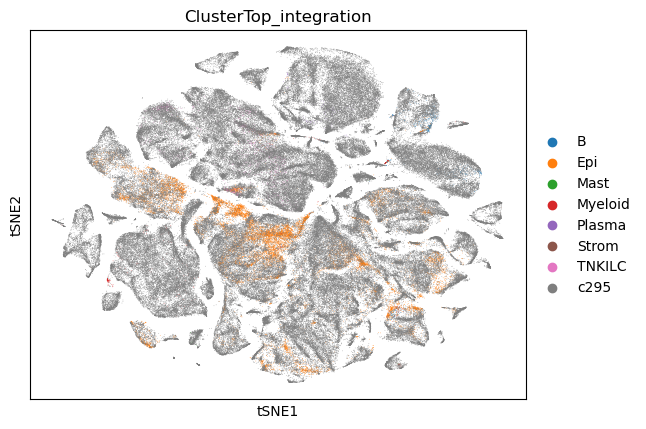

In [45]:
sc.pl.tsne(adata, color="ClusterTop_integration", size=1, alpha=0.8)

In [153]:
adata.obs['ClusterTop_integration'].value_counts()

ClusterTop_integration
c295       200000
Epi         16337
TNKILC       1360
B             692
Myeloid       344
Plasma        154
Strom          40
Mast           39
Name: count, dtype: int64

# cluster epithelial cells using their isoform expression

In [1321]:
# in the cells that are identified as epithelial, recluster using isoform data to find isoform programs/transcriptional states

In [1322]:
#long read isoform expression 
lr_isoform_path = '/mnt/lareaulab/carmelle/longread_sc/crc1/PacBio-isoform_counts_matrix_ad.h5ad'

In [1323]:
lr_isoform = sc.read_h5ad(lr_isoform_path)

In [1324]:
lr_isoform

AnnData object with n_obs × n_vars = 287458 × 125205
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library_id_IL', 'condition', 'ClusterTop', 'ClusterMidway', 'ClusterMidway2', 'ClusterFull', 'ClusterFull2', 'library_id_PB'
    var: 'chrom', 'start', 'end', 'GeneSymbol', 'SupportingStructCategory', 'WithinCAGEPeak', 'WithinPolyAPeak', 'NExons'

In [1325]:
sc.pp.filter_genes(lr_isoform, min_cells=3)

#have to be very lose with filtering cells because we have very few cells have isoform data to begin with
sc.pp.filter_cells(lr_isoform, min_genes=3)

In [1326]:
sc.pp.calculate_qc_metrics(lr_isoform, inplace=True)

In [1327]:
lr_isoform

AnnData object with n_obs × n_vars = 17760 × 29255
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library_id_IL', 'condition', 'ClusterTop', 'ClusterMidway', 'ClusterMidway2', 'ClusterFull', 'ClusterFull2', 'library_id_PB', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'chrom', 'start', 'end', 'GeneSymbol', 'SupportingStructCategory', 'WithinCAGEPeak', 'WithinPolyAPeak', 'NExons', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

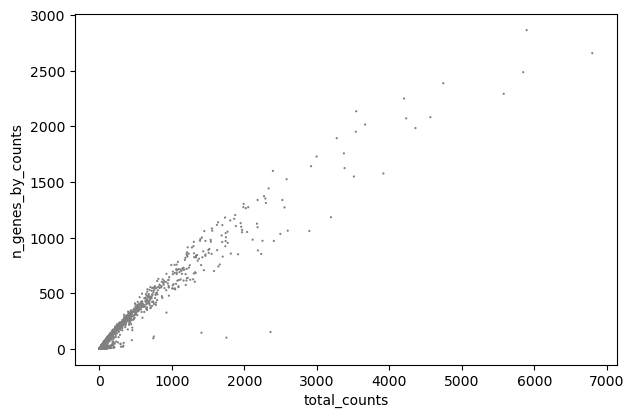

In [1328]:
sc.pl.scatter(lr_isoform, x='total_counts', y='n_genes_by_counts', size=10)

In [1329]:
lr_isoform.obs['condition'].value_counts()

condition
normal    4406
tumor     3229
Name: count, dtype: int64

In [1330]:
lr_isoform.obs['ClusterTop'].value_counts()

ClusterTop
Epi        6411
TNKILC      588
B           377
Myeloid     143
Plasma       81
Mast         25
Strom        10
Name: count, dtype: int64

In [1331]:
#It looks like most of our isoform expression data are form epithelial cells so let's try to look at 
#clusters of isoform expression in epithelial cells

epi_iso = lr_isoform[lr_isoform.obs['ClusterTop'] == 'Epi', :].copy()
epi_iso

AnnData object with n_obs × n_vars = 6411 × 29255
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library_id_IL', 'condition', 'ClusterTop', 'ClusterMidway', 'ClusterMidway2', 'ClusterFull', 'ClusterFull2', 'library_id_PB', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'chrom', 'start', 'end', 'GeneSymbol', 'SupportingStructCategory', 'WithinCAGEPeak', 'WithinPolyAPeak', 'NExons', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [1332]:
# again, total isoform counts per cell is pretty ok ... but only across an average of 69 isoforms per cell

np.mean(epi_iso.obs['n_genes_by_counts']), np.mean(epi_iso.obs['nCount_RNA'])

(np.float64(69.27234440804867), np.float64(5478.705350179379))

In [1333]:
sc.tl.pca(epi_iso)
sc.pp.neighbors(epi_iso, n_pcs=10, n_neighbors=15)

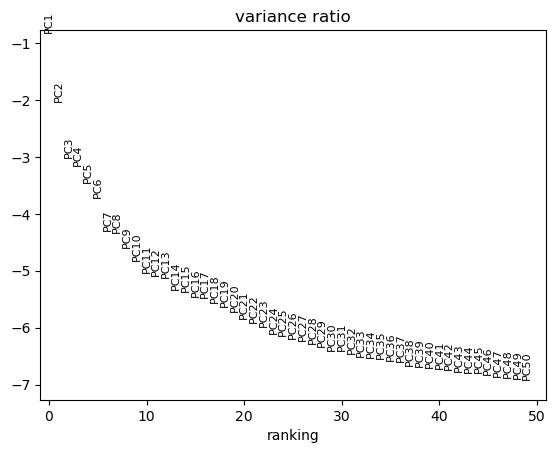

In [1334]:
sc.pl.pca_variance_ratio(epi_iso, n_pcs=50, log=True)

In [1335]:
#let's try to visualize the epithelial isoform data

sc.tl.pca(epi_iso)
sc.pp.neighbors(epi_iso, n_pcs=10, n_neighbors=15)

In [1336]:
#umap
sc.tl.umap(epi_iso)

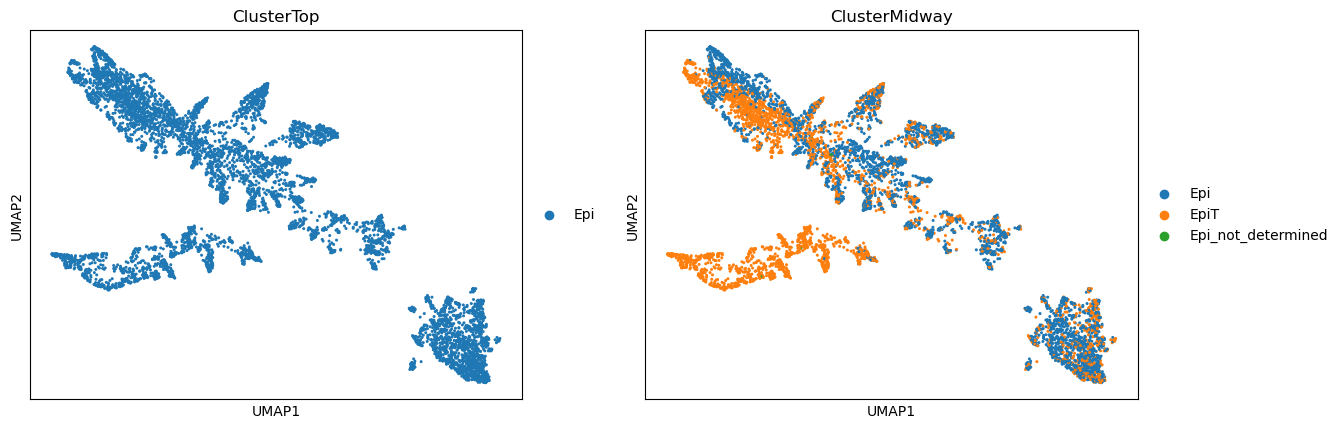

In [1337]:
sc.pl.umap(epi_iso, color=['ClusterTop', 'ClusterMidway'])

In [1338]:
#now do leiden clustering on the epithelial cells using isoform data
sc.tl.leiden(epi_iso, resolution=0.01)

In [1339]:
# Test a range of resolutions
for res in [0.01, 0.05, 0.1, 0.2, 0.4]:
    key = 'epithelial_iso_res' + str(res)
    sc.tl.leiden(epi_iso, resolution=res, key_added=key)
    adata.obs[adata_key] = epi_iso.obs[key]
    n_clusters = epi_iso.obs[key].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

Resolution 0.01: 2 clusters
Resolution 0.05: 5 clusters
Resolution 0.1: 8 clusters
Resolution 0.2: 12 clusters
Resolution 0.4: 16 clusters


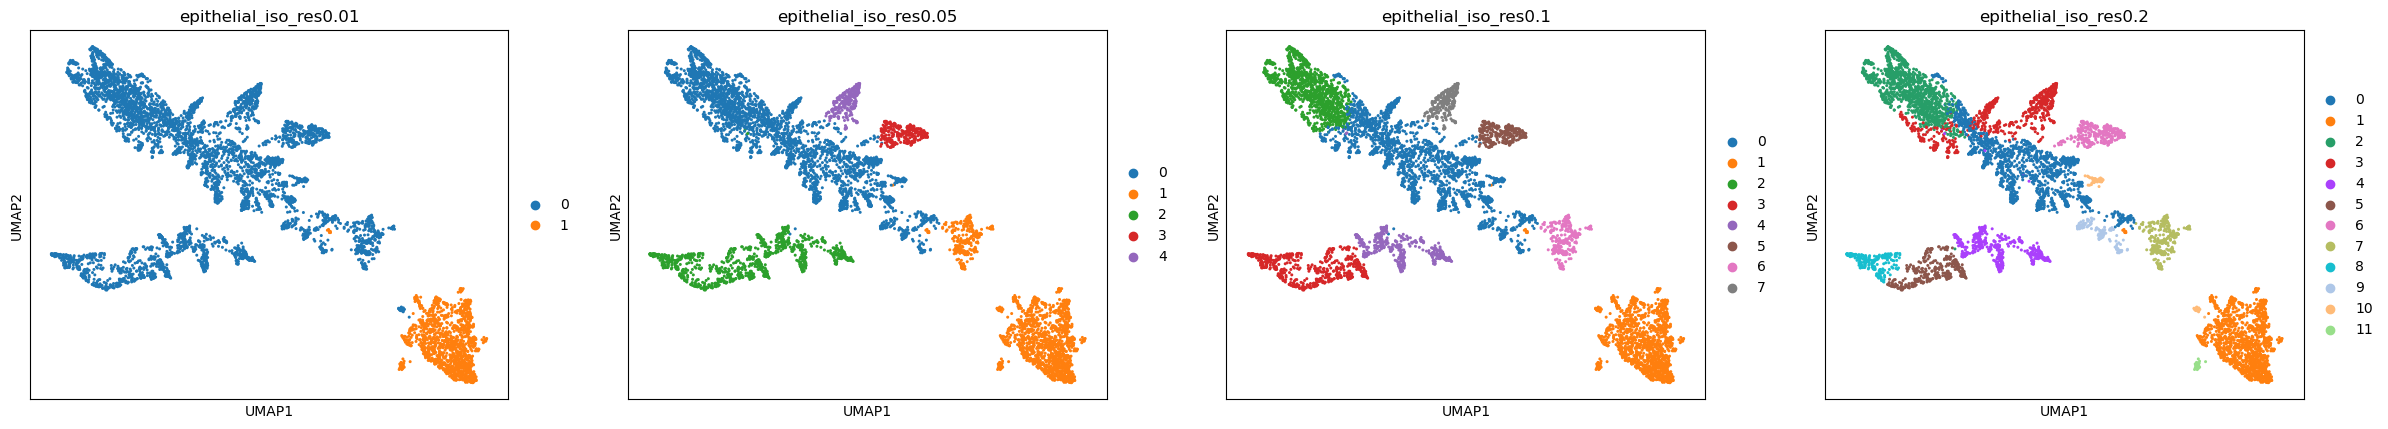

In [1340]:
sc.pl.umap(epi_iso, color=['epithelial_iso_res0.01', 'epithelial_iso_res0.05', 'epithelial_iso_res0.1', 'epithelial_iso_res0.2'])

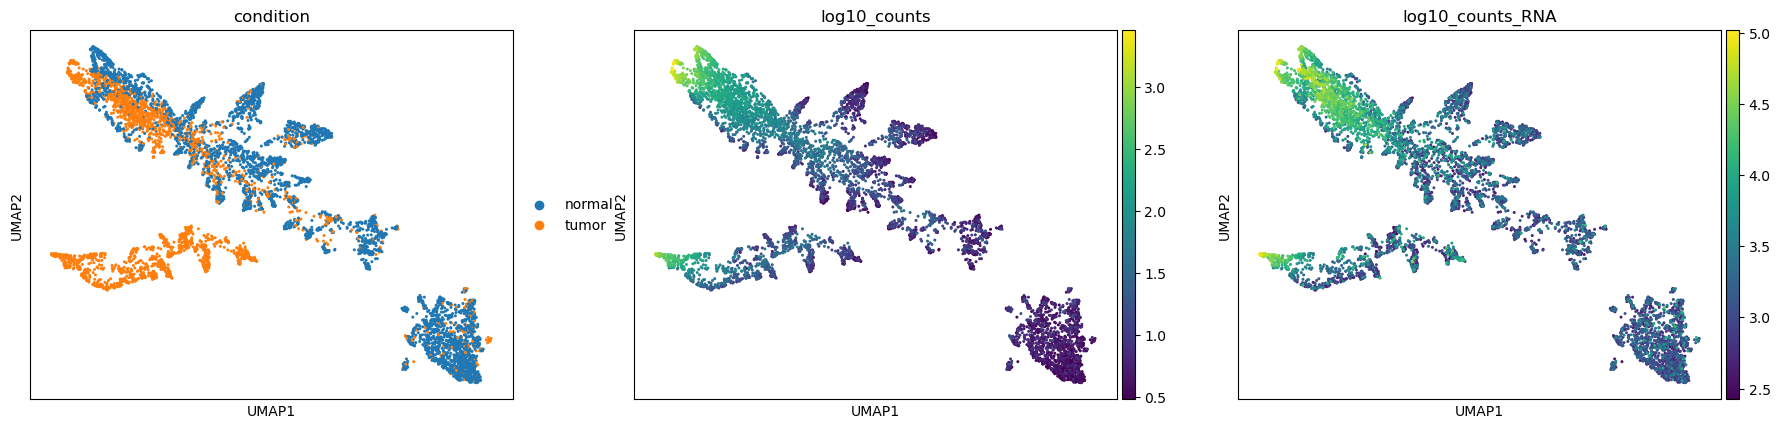

In [1341]:
#look at some quality metrics to help decide which clusters to do DE and understand the unstable clustering of some cells

epi_iso.obs['log10_counts'] = np.log10(epi_iso.obs['n_genes_by_counts'])
epi_iso.obs['log10_counts_RNA'] = np.log10(epi_iso.obs['nCount_RNA'])

sc.pl.umap(epi_iso, color=['condition','log10_counts', 'log10_counts_RNA'])

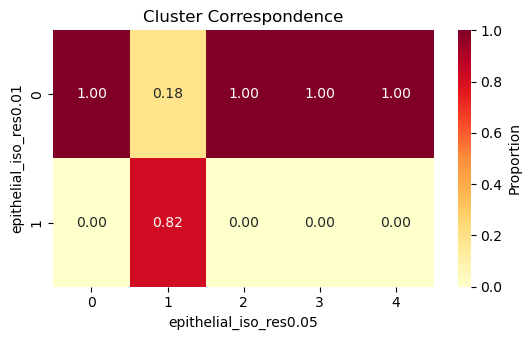

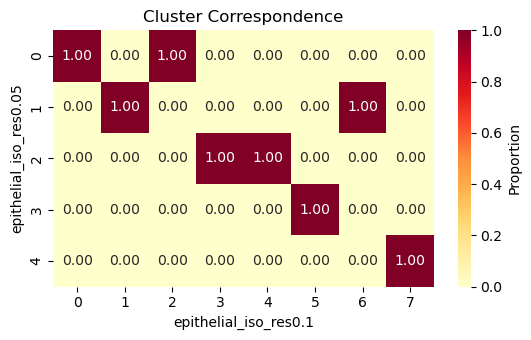

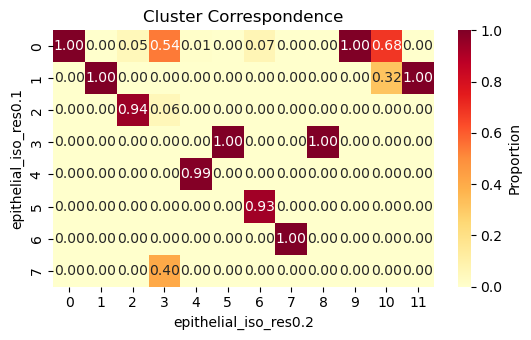

In [1342]:
plot_contingency(epi_iso, 'epithelial_iso_res0.01', 'epithelial_iso_res0.05')
plot_contingency(epi_iso, 'epithelial_iso_res0.05', 'epithelial_iso_res0.1')
plot_contingency(epi_iso, 'epithelial_iso_res0.1', 'epithelial_iso_res0.2')

cluster 2 condition
tumor     682
normal    465
Name: count, dtype: int64
cluster 8 condition
normal    520
tumor     146
Name: count, dtype: int64


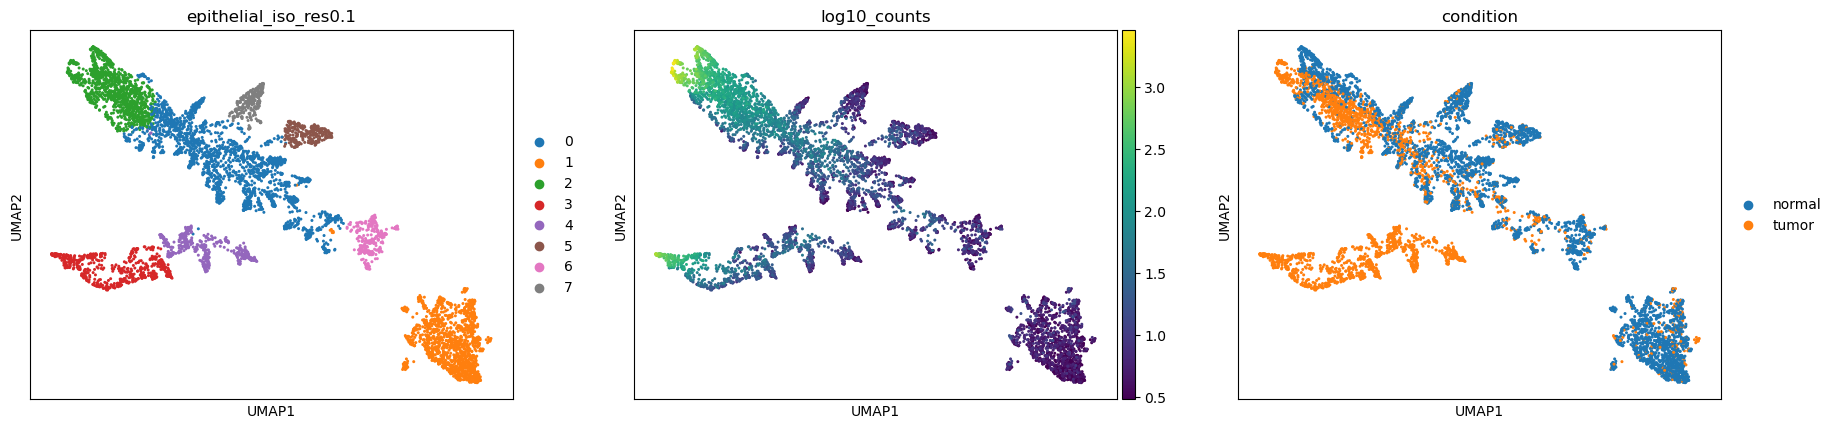

In [1343]:
# from analyzing the leiden clusters and the quality metrics (read counts per cell), looking at resolution 0.1 and comparing
# between cluster 0 and cluster 3 seem to be most promosing

print('cluster 2', epi_iso[epi_iso.obs['epithelial_iso_res0.2'] == '2'].obs['condition'].value_counts())
print('cluster 8', epi_iso[epi_iso.obs['epithelial_iso_res0.2'] == '3'].obs['condition'].value_counts())

# cluster 2 is a mix of tumor and normal cells
# cluster 3 is a tumor only cluster

sc.pl.umap(epi_iso, color=['epithelial_iso_res0.1', 'log10_counts', 'condition'])

# idenity top marker isoforms for epithelial subcluster 2 and subcluster 3

In [1344]:
# first lets map back these subclusters in the atlast, where are they?
adata.obs["epi_subclusters"] = epi_iso.obs['epithelial_iso_res0.1']

In [1345]:
adata.obs['epi_subclusters']. value_counts()

epi_subclusters
0    2030
1    1407
2    1121
3     560
4     442
5     288
6     288
7     269
Name: count, dtype: int64

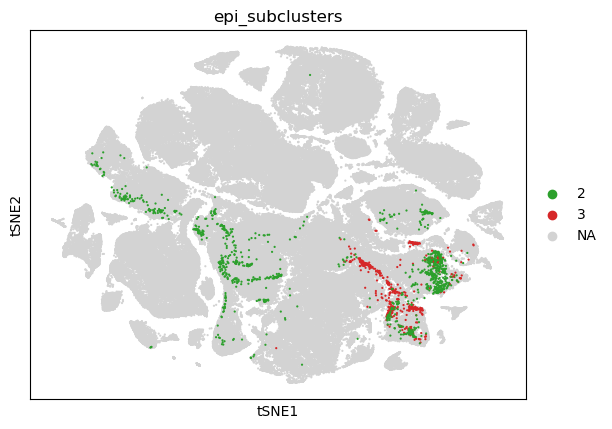

In [1346]:
sc.pl.tsne(adata, color=["epi_subclusters"], groups=['2', '3'], size=10)

In [1347]:
sc.pp.log1p(epi_iso)

In [1357]:
# now let's look at the top isoforms expressed in the clusters

sc.tl.rank_genes_groups(epi_iso, 'epithelial_iso_res0.1', groups=['2', '3'], method='wilcoxon', n_genes=29255)

In [1358]:
cluster2_de = create_de_df(epi_iso, '2')
cluster2_de.head()

/tmp/ipykernel_3962127/3651396150.py:12: RuntimeWarning: divide by zero encountered in log10
  pvals_adj = -np.log10(results['pvals_adj'][cluster])


,gene,log2fc,p_val_adj,pval,color
0,TCONS_00017589,3.903409,inf,0.000000e+00,gray
1,TCONS_00100539,4.894361,inf,0.000000e+00,gray
2,TCONS_00058781,4.942095,inf,0.000000e+00,gray
3,TCONS_00043046,3.727660,302.516760,4.160065e-307,gray
4,TCONS_00024772,4.176634,281.394308,6.893846e-286,gray


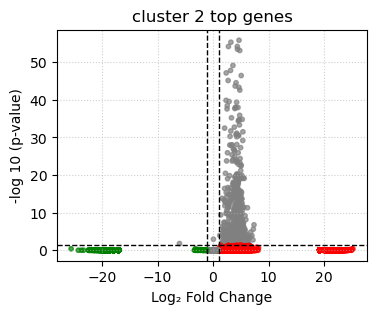

In [1365]:
plot_volcano(cluster2_de.drop([x for x in range(0, 50)]), 'cluster 2 top genes')

In [1366]:
cluster3_de = create_de_df(epi_iso, '3')
cluster3_de.head()

/tmp/ipykernel_3962127/3651396150.py:12: RuntimeWarning: divide by zero encountered in log10
  pvals_adj = -np.log10(results['pvals_adj'][cluster])


,gene,log2fc,p_val_adj,pval,color
0,TCONS_00121692,5.807542,inf,0.000000e+00,gray
1,TCONS_00121689,4.979712,130.905825,8.491903e-136,gray
2,TCONS_00121688,5.303102,103.762614,1.771363e-108,gray
3,TCONS_00121690,6.539768,86.710767,2.661294e-91,gray
4,TCONS_00075152,3.392278,45.872880,2.290289e-50,gray


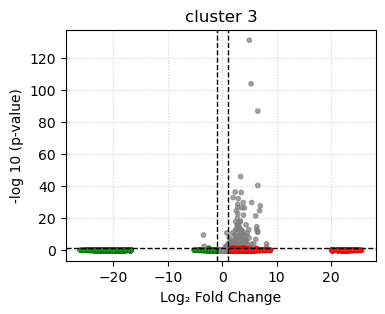

In [1367]:
plot_volcano(cluster3_de, 'cluster 3')

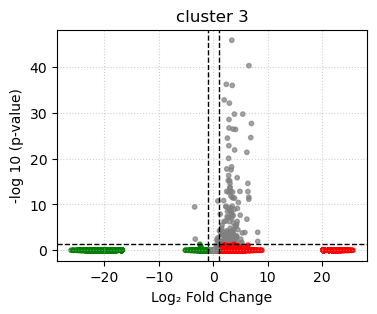

In [1368]:
# remove the p-val outlier
plot_volcano(cluster3_de.drop([0,1,2,3]), 'cluster 3')

In [1370]:
# let's look at the isoforms up/downregulated at of our tumor epithelial cells. what makes them different?

#filter for significance
cluster3_de = cluster3_de[cluster3_de.p_val_adj.apply(lambda x: x < -np.log10(0.05))]

# dont look at the outliers > 20 and < - 20 fold changes
cluster3_de = cluster3_de[cluster3_de.log2fc.apply(lambda x: (x < 10) and (x > -10))]
cluster3_de

,gene,log2fc,p_val_adj,pval,color
162,TCONS_00075503,3.773648,1.289105,0.000292,red
163,TCONS_00058728,1.895169,1.158917,0.000396,red
164,TCONS_00017979,6.366347,1.113591,0.000442,red
165,TCONS_00018073,2.006206,1.107696,0.000451,red
166,TCONS_00049640,2.289485,1.046388,0.000522,red
...,...,...,...,...,...
29248,TCONS_00025649,-1.900641,0.043647,0.007393,green
29249,TCONS_00034989,-1.335836,0.055143,0.007136,green
29250,TCONS_00019191,-2.074585,0.390660,0.002975,green
29251,TCONS_00065567,-2.311015,0.825817,0.000934,green


In [1371]:
cluster3_de.sort_values('log2fc', ascending=False)

,gene,log2fc,p_val_adj,pval,color
248,TCONS_00034969,8.908665,-0.000000,0.012057,red
235,TCONS_00106055,8.791616,0.013946,0.008044,red
286,TCONS_00058609,8.739253,-0.000000,0.025696,red
288,TCONS_00017603,8.484921,-0.000000,0.025702,red
427,TCONS_00112721,8.177494,-0.000000,0.125628,red
...,...,...,...,...,...
29209,TCONS_00066498,-4.448607,-0.000000,0.214184,green
29220,TCONS_00049661,-4.583234,-0.000000,0.158717,green
29231,TCONS_00001590,-4.739553,-0.000000,0.122756,green
29211,TCONS_00058485,-5.072941,-0.000000,0.201835,green


# convert TCONS id to gene ID of top up and down regulated isoforms

In [1372]:
# let's look at top upregulated
cluster3_top_up = cluster3_de.sort_values('log2fc', ascending=False)['gene'][:20].tolist()
cluster3_top_down = cluster3_de.sort_values('log2fc', ascending=True)['gene'][:20].tolist()

In [1373]:
up_ensembl_id = transcript_name_converter(cluster3_top_up)
down_ensembl_id = transcript_name_converter(cluster3_top_down)

In [1374]:
up_ensembl_id[:5], down_ensembl_id[:5]

(['ENSG00000080824',
  'ENSG00000106211',
  'ENSG00000105388',
  'ENSG00000251562',
  'ENSG00000178719'],
 ['ENSG00000111716',
  'ENSG00000167642',
  'ENSG00000116209',
  'ENSG00000170296',
  'ENSG00000115944'])

In [1375]:
upregulated_genes = get_gene_symbols(up_ensembl_id)
downregulated_genes = get_gene_symbols(down_ensembl_id)

In [1376]:
upregulated_genes

['HSP90AA1',
 'HSPB1',
 'CEACAM5',
 'MALAT1',
 'GRINA',
 'MPC2',
 'POR',
 'H3C14',
 'PFKL',
 'TMEM259',
 'H19',
 'RABL6',
 'PLOD3',
 'PAK2',
 'ALDOA',
 'ITGB4',
 'PFKL',
 'TMEM63A',
 'VCP']

In [1377]:
downregulated_genes

['LDHB',
 'SPINT2',
 'TMEM59',
 'GABARAP',
 'COX7A2L',
 'TXN',
 'UBXN1',
 'MDH1',
 'HSP90AA1',
 'NR2F6',
 'CFL1',
 'FOS',
 'YBX1',
 'VDAC2',
 'PRDX3',
 'EEF2',
 'SRSF9',
 'OSTC',
 'GABARAPL2',
 'YWHAH']

# helper functions

In [1015]:
def plot_volcano(plotting_df, title): 
    plt.figure(figsize=(4, 3))
    plt.scatter(x=plotting_df['log2fc'], y=plotting_df['p_val_adj'], c=plotting_df['color'], s=10, alpha=0.7)
    
    # 4. Add reference lines for significance and fold change
    plt.axhline(y=pval_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=log2fc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-log2fc_thresh, color='black', linestyle='--', linewidth=1)
    
    
    plt.xlabel('Log₂ Fold Change')
    plt.ylabel('-log 10 (p-value)')
    plt.title(title)
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

In [992]:
# Define significance thresholds
pval_thresh = -np.log10(0.05)
log2fc_thresh = 1

def create_de_df(adata, cluster):
    # Access rank_genes_groups from adata
    results = adata.uns['rank_genes_groups']
    
    # Extract data for the specific cluster

    logfc = results['logfoldchanges'][cluster]
    pvals_adj = -np.log10(results['pvals_adj'][cluster])
    pvals = results['pvals'][cluster]
    genes = results['names'][cluster]
    
    
    plotting_df = pd.DataFrame({'gene': genes, 'log2fc': logfc, 'p_val_adj': pvals_adj, 'pval': pvals})
    
    #significant up/down (red/green) not significant (gray)
    plotting_df['color'] = 'gray' # Default color
    plotting_df.loc[(plotting_df['p_val_adj'] < pval_thresh) & (plotting_df['log2fc'] > log2fc_thresh), 'color'] = 'red'    # Upregulated
    plotting_df.loc[(plotting_df['p_val_adj'] < pval_thresh) & (plotting_df['log2fc'] < -log2fc_thresh), 'color'] = 'green' # Downregulated

    return plotting_df

In [971]:
import seaborn as sns

def plot_contingency(adata, key1, key2):
    contingency = pd.crosstab(
    adata.obs[key1],  
    adata.obs[key2],
    normalize='columns')
    
    plt.figure(figsize=(5.5, 3.5))
    sns.heatmap(contingency, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Proportion'})
    plt.xlabel(key2)
    plt.ylabel(key1)
    plt.title('Cluster Correspondence')
    plt.tight_layout()
    plt.show()

In [535]:
# the andata var hold the TCONS id conversion
epi_iso.var['GeneSymbol']

TCONS_00011259                    novelGene_RefSeq__LOC124900618_AS
TCONS_00011260                           GENCODE__ENSG00000225972.1
TCONS_00007975                           GENCODE__ENSG00000225972.1
TCONS_00000001                           GENCODE__ENSG00000225630.1
TCONS_00009624                           GENCODE__ENSG00000237973.1
                                        ...                        
TCONS_00125121              novelGene_GENCODE__ENSG00000230029.1_AS
TCONS_00125205                                       novelGene_1086
TCONS_00125151                                         LOC105377236
TCONS_00125152                                       novelGene_1087
TCONS_00125153    GENCODE__ENSG00000229238.3___GENCODE__ENSG0000...
Name: GeneSymbol, Length: 125205, dtype: category
Categories (20151, object): ['AKAP17A', 'ANAPC1P2', 'ANP32A-IT1', 'ARHGAP27P1', ..., 'novelGene_RefSeq__LOC124906230_AS', 'novelGene_RefSeq__LOC124906254_AS', 'novelGene_RefSeq__LOC124909408_AS', 'novel

In [965]:
# create a conversion map TCONS ID -> ENSEMBL ID -> GENE SYMBOL
# this is TCONS ID -> ENSEMBL ID 
ensembl_convert = dict(zip(lr_isoform.var['GeneSymbol'].index, lr_isoform.var['GeneSymbol'].values))

ensembl_ids = []

for x in ensembl_convert.values():
    try:
        ensembl_ids.append(x.split('__')[1].split('.')[0])
    except IndexError:
        ensembl_ids.append(x)

In [1219]:
# now do ENSEMBL ID -> GENE SYMBOL
from pybiomart import Server

server = Server(host='http://www.ensembl.org')
mart = server['ENSEMBL_MART_ENSEMBL']
dataset = mart['hsapiens_gene_ensembl']

ensembl_to_name = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

ensembl_to_name.columns = ['gene_id', 'gene_symbol']
ensembl_to_name = ensembl_to_name[ensembl_to_name['gene_symbol'].notna()]
ensembl_to_name.head()

,gene_id,gene_symbol
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV
3,ENSG00000210082,MT-RNR2
4,ENSG00000209082,MT-TL1


In [1249]:
def get_gene_symbols(id_list):
    names = []
    ensembl = ensembl_to_name.set_index('gene_id')
    for x in id_list:
        try:
            names.append(ensembl.loc[x]['gene_symbol'])
        except KeyError:
            #no conversion name available, pass
            pass
    return names

In [1221]:
def transcript_name_converter(id_list):
    ensembl_id = []
    clean_ids = []
    
    for x in id_list:
        ensembl_id.append(ensembl_convert[x])
    
    for y in ensembl_id:
        try:
            id_clean = y.split('__')[1].split('.')[0]
            clean_ids.append(id_clean)  
        except IndexError:
            clean_ids.append(y)
    return clean_ids